# Comparing the Dynamics of Regular and Mass-Conserved FitzHugh–Nagumo Systems

**Motivation:**  
The FitzHugh–Nagumo (FHN) model is widely used for excitable dynamics with applications in biology and chemistry. Recently, active matter studies have highlighted the role of non-reciprocal energy injection and mass conservation. In this notebook we:
 
1. **Formulate the Models:** Define the regular FHN system and a mass‑conserved version.
2. **Local Dynamics Analysis:** Perform a linear stability analysis of the homogeneous steady states for both systems to reveal differences in stability and bifurcation behavior.
3. **Spatial Pattern Formation:** Use finite‑difference simulations to explore wave propagation, pattern formation, and the influence of the conservation law.
 
---
 
**Main Equations:**
 
**Regular FHN System:**
   $$
   \begin{aligned}
      \frac{\partial u}{\partial t} &= f(u,v) + D_u \nabla^2 u,\\[1mm]
      \frac{\partial v}{\partial t} &= \epsilon\, g(u,v) + D_v \nabla^2 v,
   \end{aligned}
   $$ 
   with
   $$ 
   
     f(u,v) = u-\frac{u^3}{3} - v,\quad 
     g(u,v)= u + a - b\,v.
   $$
 
**Mass-Conserved FHN System:**
   $$
   \begin{aligned}
      \frac{\partial u}{\partial t} &= -\nabla^2\Bigl[f(u,v) + D_u \nabla^2 \Bigr],\\[1mm]
      \frac{\partial v}{\partial t} &= -\nabla^2\Bigl[\epsilon\, g(u,v) + D_v \nabla^2 v\Bigr].
   \end{aligned}
   $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from scipy.stats import linregress

## 2. Local Dynamics Analysis: Homogeneous Steady States and Linear Stability

For homogeneous (spatially constant) solutions the diffusion terms vanish. The fixed point (FP)
must satisfy:

\begin{aligned}
f(u, v) &= u-\frac{u^3}{3} - v = 0,\\[1mm]
g(u, v) &= u + a - b\,v = 0.
\end{aligned}

Eliminating $v$ (i.e. $v = u - \frac{u^3}{3}$) $$ in the second equation leads to the cubic:
$$
\frac{b}{3}u^3 + (1 - b) u + a = 0.
$$
We use `np.roots` to solve this cubic and then compute the corresponding \(v\) values.
 
The Jacobian for the regular FHN (reaction part) is:

$$
J = \begin{pmatrix}
1-u^2 & -1\\[1mm]
\epsilon & -\epsilon\,b
\end{pmatrix}.
$$

The eigenvalues of \(J\) determine the local stability of the FP. For the mass‑conserved system, the
homogeneous FP are the same (the diffusion terms vanish), but spatial perturbations with nonzero wavenumbers alter the stability.

In [2]:
# Reaction functions
def f(u, v):
    return u - u**3 / 3 - v


def g(u, v, a, b):
    return u + a - b * v


# Helper functions
def steady_state_fp(a, b):
    coeffs = [b / 3, 0, (1 - b), a]
    roots = np.roots(coeffs)
    u_fp = np.real(roots[np.isclose(np.imag(roots), 0)])
    v_fp = u_fp - (u_fp**3) / 3
    return u_fp, v_fp


def jacobian(u_fp, epsilon, b):
    return np.array([[1 - u_fp**2, -1], [epsilon, -epsilon * b]])


def analyze_fp(a, b, epsilon):
    u_vals, v_vals = steady_state_fp(a, b)
    print("Fixed Points (u, v):")
    for u_fp, v_fp in zip(u_vals, v_vals):
        print(f"u = {u_fp:.4f}, v = {v_fp:.4f}")
        J = jacobian(u_fp, epsilon, b)
        eigs = np.linalg.eigvals(J)
        print("Eigenvalues:", eigs, "\n")


def dispersion_relation(a, b, epsilon, Du, Dv, ks):
    u0 = steady_state_fp(a, b)[0][0]
    reg = [
        max(
            LA.eigvals(
                [[1 - u0**2 - Du * k**2, -1], [epsilon, -epsilon * b - Dv * k**2]]
            ).real
        )
        for k in ks
    ]
    mc = [
        max(
            LA.eigvals(
                [
                    [k**2 * (1 - u0**2) - Du * k**4, -(k**2)],
                    [epsilon * k**2, -epsilon * b * k**2 - Dv * k**4],
                ]
            ).real
        )
        for k in ks
    ]
    return np.array(reg), np.array(mc)

In [3]:
# Parameters
a = 0.1
b = 2
epsilon = 0.01
Du = 1.0
Dv = 2.0
n_space = 100

domain = (0, 200)

# dx = 1.0
dx = (domain[1] - domain[0]) / n_space
dt_max = dx**4 / (8 * Du)
dt = min(0.01, dt_max * 0.5)

In [4]:
# Analysis of the fixed point
analyze_fp(a, b, epsilon)

Fixed Points (u, v):
u = -1.2720, v = -0.5860
Eigenvalues: [-0.60070621 -0.03722041] 

u = 1.1713, v = 0.6356
Eigenvalues: [-0.34076098 -0.05117586] 

u = 0.1007, v = 0.1003
Eigenvalues: [ 0.97986208 -0.00999862] 



## 3. Spatial Pattern Formation: Simulations
 
We now simulate the spatially-extended versions of the systems by discretizing space (using finite differences) and time (using a forward-Euler scheme).
 
The following functions implement:
 
**Regular FHN:**
$$
   \begin{aligned}
   \partial_t u &= f(u,v) + D_u \nabla^2u,\\[1mm]
   \partial_t v &= \epsilon\,g(u,v) + D_v \nabla^2v,
   \end{aligned}
$$

 
**Mass-Conserved FHN:**
$$
   \begin{aligned}
   \partial_t u &= -\nabla^2\Bigl[f(u,v)+D_u \nabla^2u\Bigr],\\[1mm]
   \partial_t v &= -\nabla^2\Bigl[\epsilon\,g(u,v)+D_v \nabla^2v\Bigr].
   \end{aligned}
$$
 
You can choose which system to simulate by uncommenting the corresponding block.


In [ ]:
# Build neighbor indices for lattice Laplacian
def build_neighbors(n, bc="periodic"):
    N = n * n
    inds = np.arange(N).reshape(n, n)
    nbrs = []
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        if bc == "periodic":
            nbr = np.roll(np.roll(inds, di, axis=0), dj, axis=1).ravel()
        else:
            nbr = []
            for i in range(n):
                for j in range(n):
                    ni, nj = i + di, j + dj
                    nbr.append(inds[ni, nj] if 0 <= ni < n and 0 <= nj < n else N)
            nbr = np.array(nbr)
        nbrs.append(nbr)
    return np.vstack(nbrs), 4


def generate_initial_uv(n, a, b, excited_percentage=0.2, excited_val=0.8):
    u_vals, v_vals = steady_state_fp(a, b)
    u_fp = np.min(u_vals)
    v_fp = v_vals[np.argmin(u_vals)]

    ug = u_fp * np.ones((n, n)) + np.random.randn(n, n)
    vg = v_fp * np.ones((n, n)) + np.random.randn(n, n)

    mid = ug[:, 0].size // 2
    mid_range = int((ug[:, 0].size * excited_percentage) / 2)
    ug[mid - mid_range : mid + mid_range, mid - mid_range : mid + mid_range] = (
        excited_val + np.random.randn(2 * mid_range, 2 * mid_range)
    )

    return ug, vg


# Simulation: regular FHN with selective saving
def simulate_regular_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv, save_every=1, bc="periodic"
):
    x0, x1 = domain
    dx = (x1 - x0) / n_space
    t_vec_full = np.arange(0, T + dt, dt)
    nbrs, mult = build_neighbors(n_space, bc)
    u, v = generate_initial_uv(n_space, a, b)
    # u = u + 0.01 * np.random.randn(n_space, n_space)
    # v = v + 0.01 * np.random.randn(n_space, n_space)
    u_list, v_list = [], []
    for idx, _ in enumerate(t_vec_full[1:], start=1):
        uf, vf = u.ravel(), v.ravel()
        u_ext = np.concatenate([uf, [0.0]])
        v_ext = np.concatenate([vf, [0.0]])
        Lu = (u_ext[nbrs].sum(axis=0) - mult * uf) / (dx**2)
        Lv = (v_ext[nbrs].sum(axis=0) - mult * vf) / (dx**2)
        Lu, Lv = Lu.reshape(n_space, n_space), Lv.reshape(n_space, n_space)
        u = u + dt * (f(u, v) + Du * Lu)
        v = v + dt * (epsilon * g(u, v, a, b) + Dv * Lv)
        if idx % save_every == 0:
            u_list.append(u.copy())
            v_list.append(v.copy())
    t_sampled = t_vec_full[save_every::save_every]
    X = Y = np.linspace(x0, x1, n_space)
    return X, Y, t_sampled, np.array(u_list), np.array(v_list)


# Simulation: mass-conserved FHN with selective saving
def simulate_mass_conserved_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv, save_every=1, bc="periodic"
):
    x0, x1 = domain
    dx = (x1 - x0) / n_space
    t_vec_full = np.arange(0, T + dt, dt)
    nbrs, mult = build_neighbors(n_space, bc)
    u, v = generate_initial_uv(n_space, a, b)
    # u = 0.1 + 0.01 * np.random.randn(n_space, n_space)
    # v = 0.1 + 0.01 * np.random.randn(n_space, n_space)
    u_list, v_list = [], []
    for idx, _ in enumerate(t_vec_full[1:], start=1):
        uf, vf = u.ravel(), v.ravel()
        u_ext = np.concatenate([uf, [0.0]])
        v_ext = np.concatenate([vf, [0.0]])
        Lu = (u_ext[nbrs].sum(axis=0) - mult * uf) / (dx**2)
        Lv = (v_ext[nbrs].sum(axis=0) - mult * vf) / (dx**2)
        inner_u = f(u, v) + Du * Lu.reshape(n_space, n_space)
        inner_v = epsilon * g(u, v, a, b) + Dv * Lv.reshape(n_space, n_space)
        iu, iv = inner_u.ravel(), inner_v.ravel()
        iu_ext, iv_ext = np.concatenate([iu, [0.0]]), np.concatenate([iv, [0.0]])
        L2u = (iu_ext[nbrs].sum(axis=0) - mult * iu) / (dx**2)
        L2v = (iv_ext[nbrs].sum(axis=0) - mult * iv) / (dx**2)
        u = u - dt * L2u.reshape(n_space, n_space)
        v = v - dt * L2v.reshape(n_space, n_space)
        if idx % save_every == 0:
            u_list.append(u.copy())
            v_list.append(v.copy())
    t_sampled = t_vec_full[save_every::save_every]
    X = Y = np.linspace(x0, x1, n_space)
    return X, Y, t_sampled, np.array(u_list), np.array(v_list)

## 4. Visualization

We now compare snapshots of the fields (activator u and inhibitor v) and animate the evolution of u for both models.

In [6]:
# Plotting helper
def plot_field(ax, X, Y, field, title="u"):
    pcm = ax.pcolormesh(X, Y, field, shading="auto", cmap="inferno")
    ax.set_aspect("equal")
    ax.set_title(title)
    plt.colorbar(pcm, ax=ax)

In [7]:
print(f"Using dt = {dt:.5f} (<= stability limit {dt_max:.5f})")

# Choose how often to save frames (to limit memory)
# e.g., save_every = 50 means store 1 frame every 50 steps
save_every = 50
print(f"Saving every {save_every} steps.")

Using dt = 0.01000 (<= stability limit 2.00000)
Saving every 50 steps.


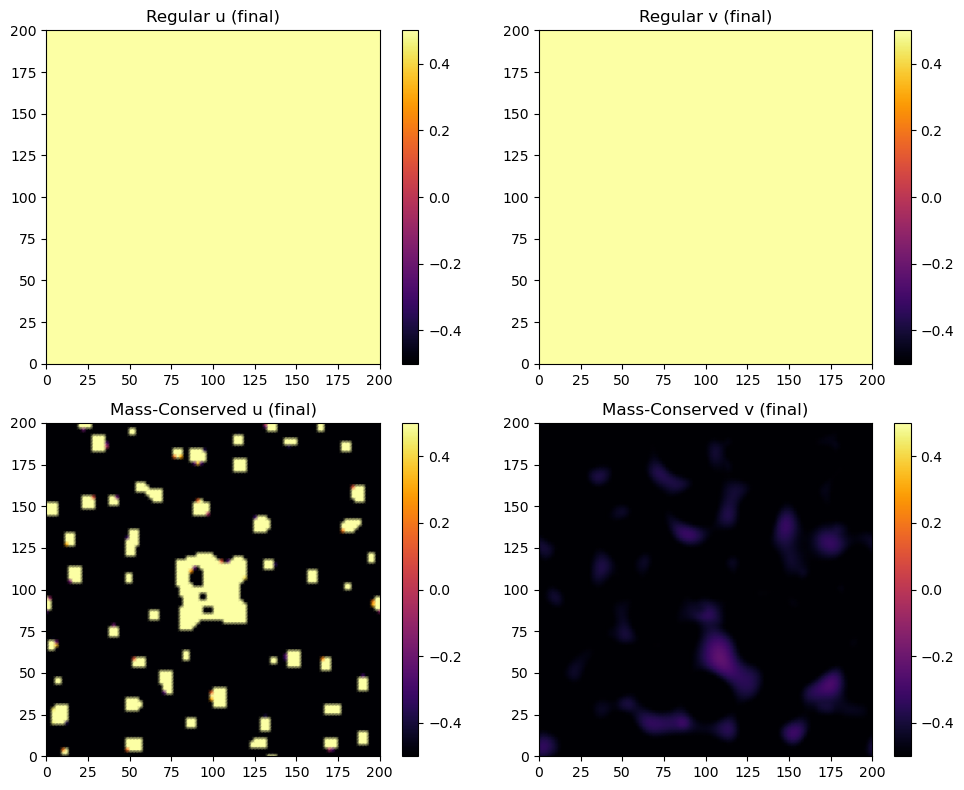

In [8]:
# Analysis & plotting
# Parameters
T, a, b, epsilon = 100, 0.1, 2.0, 0.01

# Simulations
Xr, Yr, tr, ur, vr = simulate_regular_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv, save_every=save_every
)
Xm, Ym, tm, um, vm = simulate_mass_conserved_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv, save_every=save_every
)


# 2. plotting with shared vmin/vmax
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, data, title in [
    (axes[0, 0], ur[-1], "Regular u (final)"),
    (axes[0, 1], vr[-1], "Regular v (final)"),
    (axes[1, 0], um[-1], "Mass-Conserved u (final)"),
    (axes[1, 1], vm[-1], "Mass-Conserved v (final)"),
]:
    pcm = ax.pcolormesh(
        Xr, Yr, data, shading="gouraud", cmap="inferno", vmin=-0.5, vmax=0.5
    )
    ax.set_title(title)
    ax.set_aspect("equal")
    plt.colorbar(pcm, ax=ax)

plt.tight_layout()
plt.show()

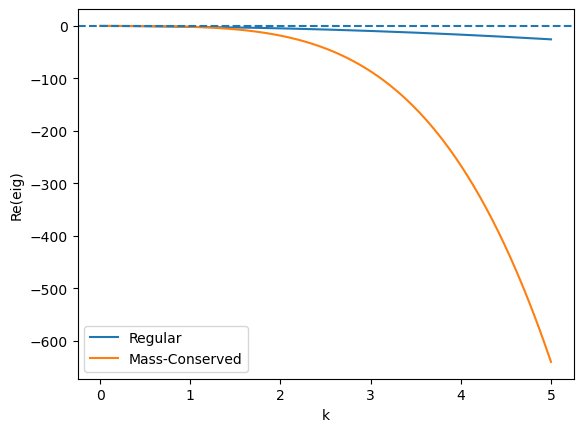

In [9]:
# Dispersion plot
ks = np.linspace(0, 5, 300)
disp_reg, disp_mc = dispersion_relation(a, b, epsilon, Du, Dv, ks)
plt.plot(ks, disp_reg, label="Regular")
plt.plot(ks, disp_mc, label="Mass-Conserved")
plt.axhline(0, linestyle="--")
plt.xlabel("k")
plt.ylabel("Re(eig)")
plt.legend()
plt.show()

## 5. Robustness Analysis to Noise and Parameter Perturbations
 
Next, we add stochastic noise to the update equations (using an Euler–Maruyama scheme) and compare the final snapshots of the activator u for both models. We run simulations with
different noise amplitudes to see how robust the spatial patterns are.


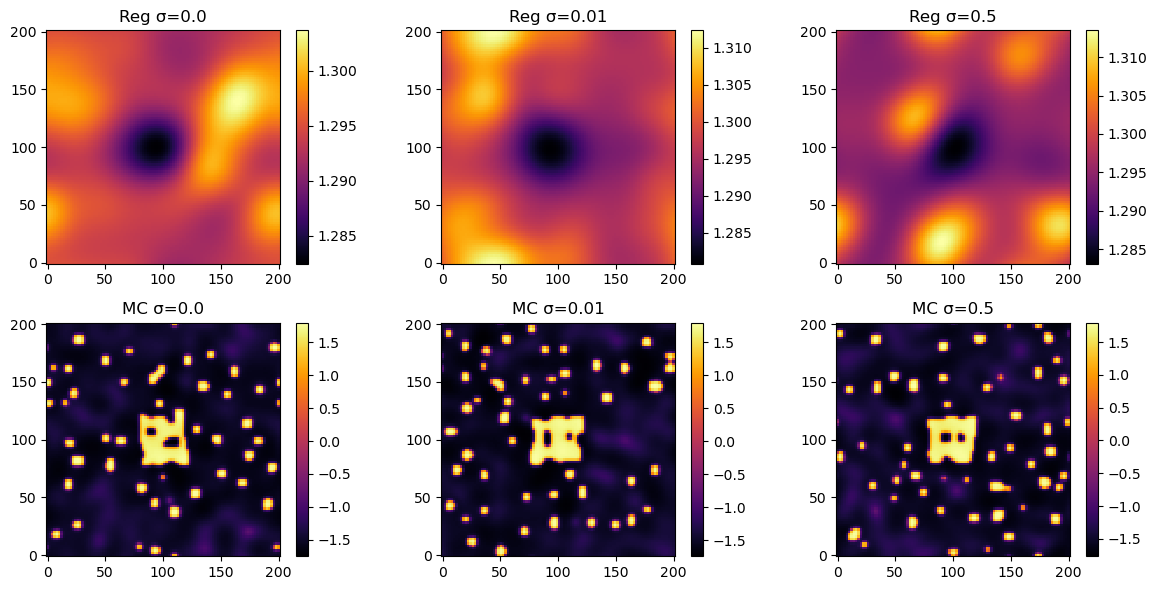

In [10]:
# Noise study
noise_levels = [0.0, 0.01, 0.5]
final_r, final_m = [], []
for sigma in noise_levels:
    _, _, _, ur_n, _ = simulate_regular_fhn(
        T, dt, n_space, domain, a, b, epsilon, Du, Dv
    )
    _, _, _, um_n, _ = simulate_mass_conserved_fhn(
        T, dt, n_space, domain, a, b, epsilon, Du, Dv
    )
    final_r.append(ur_n[-1])
    final_m.append(um_n[-1])

fig, axes = plt.subplots(2, len(noise_levels), figsize=(12, 6))
for i, sigma in enumerate(noise_levels):
    plot_field(axes[0, i], Xr, Yr, final_r[i], f"Reg σ={sigma}")
    plot_field(axes[1, i], Xm, Ym, final_m[i], f"MC σ={sigma}")
plt.tight_layout()
plt.show()

## 6. Wave Propagations

In [11]:
# Wave Propagation Threshold Analysis
# Determine x‑axis for front detection, handling domain as int or tuple
import numpy as np

# domain may be an int (length) or iterable of two bounds
if hasattr(domain, "__iter__") and len(domain) == 2:
    x_min, x_max = domain
else:
    x_min, x_max = 0, domain
x = np.linspace(x_min, x_max, n_space)
mid_idx = n_space // 2

# Helper: measure_front_speed definition


def measure_front_speed(u_mid, x, t, threshold=0.0):
    positions = []
    for ui in u_mid:
        idx = np.where(ui >= threshold)[0]
        if idx.size < 2:
            positions.append(np.nan)
        else:
            i0 = idx[0]
            x0, x1 = x[i0 - 1], x[i0]
            u0, u1 = ui[i0 - 1], ui[i0]
            pos = x0 + (threshold - u0) * (x1 - x0) / (u1 - u0)
            positions.append(pos)
    positions = np.array(positions)
    mask = np.isfinite(positions)
    if mask.sum() < 2:
        return np.nan, positions, None
    coeffs = np.polyfit(t[mask], positions[mask], 1)
    return coeffs[0], positions, coeffs


# Sweep Du values for both models
Du_values = np.linspace(0.2, 2.0, 50)
speeds_reg, speeds_mc = [], []

for Du_test in Du_values:
    # regular FHN
    Xr, Yr, t, ur, vr = simulate_regular_fhn(
        T=100,
        dt=dt,
        n_space=n_space,
        domain=domain,
        a=a,
        b=b,
        epsilon=epsilon,
        Du=Du_test,
        Dv=Dv,
        save_every=save_every,
    )
    u_mid = ur[:, mid_idx, :]
    speed, _, _ = measure_front_speed(u_mid, x, t)
    speeds_reg.append(speed)

    # mass-conserved FHN
    X2, Y2, t2, umc, vmc = simulate_mass_conserved_fhn(
        T=100,
        dt=dt,
        n_space=n_space,
        domain=domain,
        a=a,
        b=b,
        epsilon=epsilon,
        Du=Du_test,
        Dv=Dv,
        save_every=save_every,
    )
    u_mid_mc = umc[:, mid_idx, :]
    speed_mc, _, _ = measure_front_speed(u_mid_mc, x, t2)
    speeds_mc.append(speed_mc)

In [17]:
# Convert to numpy arrays for masking
speeds_reg = np.array(speeds_reg)
speeds_mc = np.array(speeds_mc)

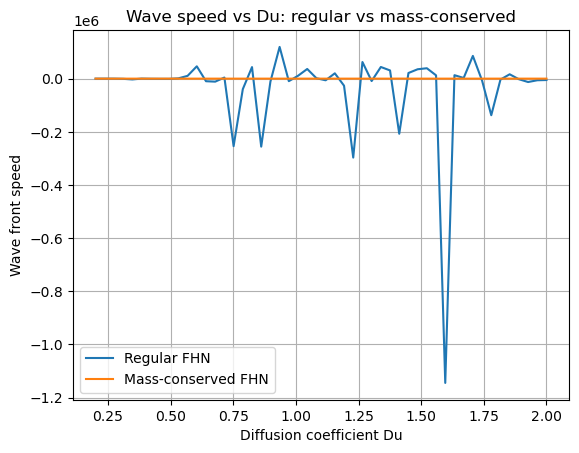

In [18]:
# Plot comparison (cf. Fig. 10D & 11C)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(Du_values, speeds_reg, "", label="Regular FHN")
plt.plot(Du_values, speeds_mc, "", label="Mass-conserved FHN")
plt.xlabel("Diffusion coefficient Du")
plt.ylabel("Wave front speed")
plt.title("Wave speed vs Du: regular vs mass-conserved")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Estimate critical Du (smallest Du with positive speed)
def critical_du(Du_vals, speeds):
    mask = speeds > 0
    return Du_vals[mask][0] if np.any(mask) else None


Du_thr_reg = critical_du(Du_values, speeds_reg)
Du_thr_mc = critical_du(Du_values, speeds_mc)
print(
    f"Regular FHN threshold Du ≈ {Du_thr_reg:.2f}"
    if Du_thr_reg
    else "Regular FHN: no propagation"
)
print(
    f"Mass-conserved FHN threshold Du ≈ {Du_thr_mc:.2f}"
    if Du_thr_mc
    else "Mass-conserved FHN: no propagation"
)

Regular FHN threshold Du ≈ 0.20
Mass-conserved FHN threshold Du ≈ 0.24


In [20]:
# Tame‑front shape comparison for both models
# Choose Du slightly above the larger of the two thresholds
Du_comp = max(Du_thr_reg or 0, Du_thr_mc or 0) * 1.1
print(f"Comparing front shapes at Du = {Du_comp:.2f}")

# Simulate both at Du_comp
Xr_c, Yr_c, t_c, ur_c, vr_c = simulate_regular_fhn(
    T=100,
    dt=dt,
    n_space=n_space,
    domain=domain,
    a=a,
    b=b,
    epsilon=epsilon,
    Du=Du_comp,
    Dv=Dv,
    save_every=save_every,
)
Xmc_c, Ymc_c, t2_c, umc_c, vmc_c = simulate_mass_conserved_fhn(
    T=100,
    dt=dt,
    n_space=n_space,
    domain=domain,
    a=a,
    b=b,
    epsilon=epsilon,
    Du=Du_comp,
    Dv=Dv,
    save_every=save_every,
)

# Select a time index where front is near mid-domain (e.g. half simulation)
time_idx = len(t_c) // 2
u_reg_profile = ur_c[time_idx, mid_idx, :]
u_mc_profile = umc_c[time_idx, mid_idx, :]

Comparing front shapes at Du = 0.26


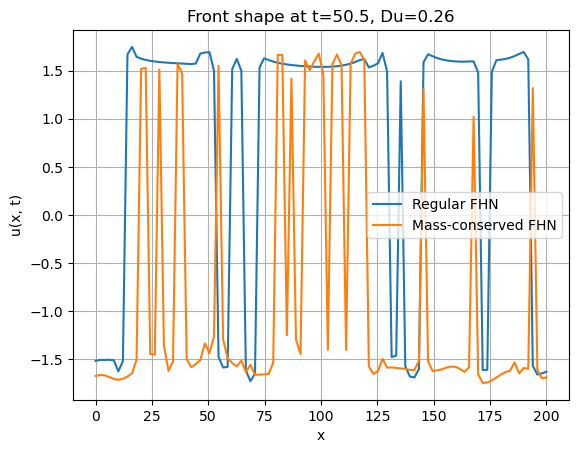

In [21]:
# Plot front profiles
plt.figure()
plt.plot(x, u_reg_profile, "", label="Regular FHN")
plt.plot(x, u_mc_profile, "", label="Mass-conserved FHN")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.title(f"Front shape at t={t_c[time_idx]:.1f}, Du={Du_comp:.2f}")
plt.legend()
plt.grid(True)
plt.show()

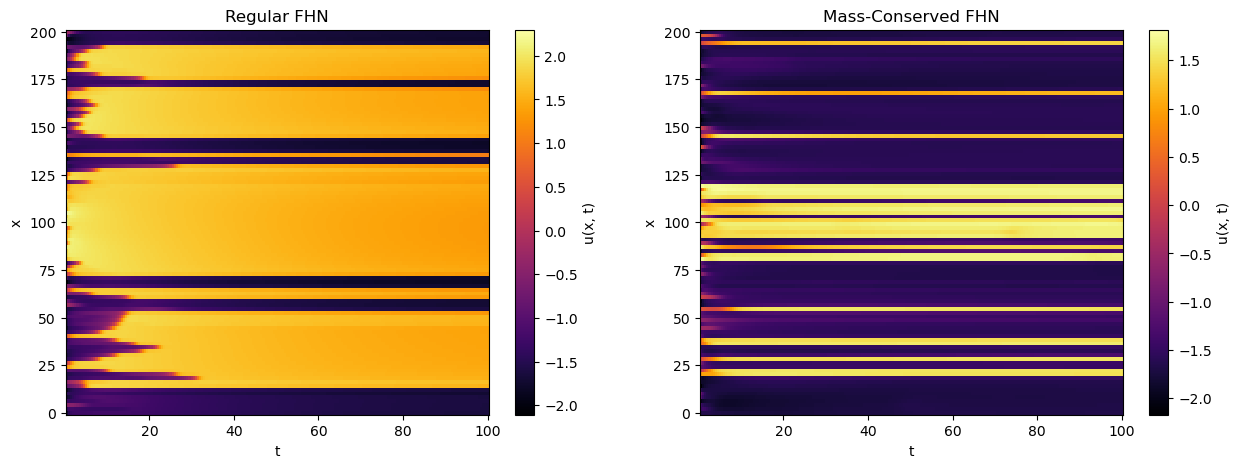

In [47]:
fig, ax = plt.subplots(1, 2, figsize=((15, 5)))
ax[0].pcolormesh(t_c, x, ur_c[:, mid_idx, :].T, shading="auto", cmap="inferno")
ax[0].set_title("Regular FHN")
ax[0].set_xlabel("t")
ax[0].set_ylabel("x")
fig.colorbar(ax[0].collections[0], ax=ax[0], label="u(x, t)")

ax[1].pcolormesh(t_c, x, umc_c[:, mid_idx, :].T, shading="auto", cmap="inferno")
ax[1].set_title("Mass-Conserved FHN")
ax[1].set_xlabel("t")
ax[1].set_ylabel("x")
fig.colorbar(ax[1].collections[0], ax=ax[1], label="u(x, t)")

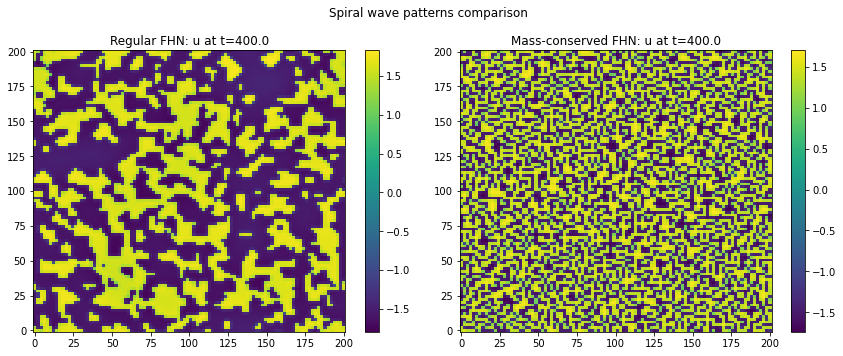

In [ ]:
# 7. Spiral wave simulation & comparison
# Use same parameters, extend time to capture spiral formation
T_spiral = 400
save_spiral = 20  # save every 20 steps to reduce data size

# Fix seed for reproducibility
np.random.seed(0)
# Regular FHN spiral
Xs_r, Ys_r, t_s, us_r, vs_r = simulate_regular_fhn(
    T=T_spiral,
    dt=dt,
    n_space=n_space,
    domain=domain,
    a=a,
    b=b,
    epsilon=epsilon,
    Du=Du_comp,
    Dv=Dv,
    save_every=save_spiral,
)
# Mass-conserved FHN spiral (reuse seed)
np.random.seed(0)
Xs_m, Ys_m, t_s2, us_m, vs_m = simulate_mass_conserved_fhn(
    T=T_spiral,
    dt=dt,
    n_space=n_space,
    domain=domain,
    a=a,
    b=b,
    epsilon=epsilon,
    Du=Du_comp,
    Dv=Dv,
    save_every=save_spiral,
)

# Plot final u-field side by side for spiral comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax = axes[0]
im0 = ax.pcolormesh(Xs_r, Ys_r, us_r[-1], shading="auto")
ax.set_title(f"Regular FHN: u at t={t_s[-1]:.1f}")
fig.colorbar(im0, ax=ax)
ax = axes[1]
im1 = ax.pcolormesh(Xs_m, Ys_m, us_m[-1], shading="auto")
ax.set_title(f"Mass‑conserved FHN: u at t={t_s2[-1]:.1f}")
fig.colorbar(im1, ax=ax)
plt.suptitle("Spiral wave patterns comparison")
plt.tight_layout()
plt.show()